# Personalized Chatbot with Long-Term Memory (LangGraph)

This notebook demonstrates how to build a **single personalized chatbot** using **LangGraph** with:

- Long-term memory via `InMemoryStore`
- Automatic memory extraction
- Personalized responses based on stored user context

The example is customized for **Sachin**, avoiding generic demo-style content.

## Environment Setup

In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

## Imports

In [2]:
import uuid
from typing import List
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage
from langchain_core.runnables import RunnableConfig

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

## Initialize Long-Term Memory Store

In [3]:
# Long-term memory store (starts empty)
store = InMemoryStore()

## System Prompt (Personalized Assistant)

In [4]:
SYSTEM_PROMPT_TEMPLATE = """
You are a personalized AI assistant with memory.

Use known user information to tailor responses naturally.

Personalization rules:
- Always address the user by name when available
- Refer to known work, tools, or interests when relevant
- Keep responses friendly, practical, and contextual

Only use facts explicitly shared by the user.

User memory:
{user_details_content}

At the end, suggest 3 relevant follow-up questions.
"""

## Memory Extraction Model

In [5]:
import os
def get_groq_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7, max_tokens=2000
    )

memory_llm = get_groq_llm()

In [7]:


class MemoryItem(BaseModel):
    text: str = Field(description="Atomic user memory")
    is_new: bool = Field(description="True if memory is new")

class MemoryDecision(BaseModel):
    should_write: bool
    memories: List[MemoryItem] = Field(default_factory=list)

memory_extractor = memory_llm.with_structured_output(MemoryDecision)

## Memory Extraction Prompt

In [6]:
MEMORY_PROMPT = """
You manage long-term user memory.

EXISTING MEMORY:
{user_details_content}

TASK:
- Extract stable user facts or preferences
- Mark is_new=true only if information is new
- Keep memories short and factual
- No assumptions
"""

## Node 1: Remember User Information

In [8]:
def remember_node(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    ns = ("user", user_id, "details")

    items = store.search(ns)
    existing = "\n".join(it.value["data"] for it in items) if items else "(empty)"

    last_msg = state["messages"][-1].content

    decision: MemoryDecision = memory_extractor.invoke([
        SystemMessage(content=MEMORY_PROMPT.format(user_details_content=existing)),
        {"role": "user", "content": last_msg},
    ])

    if decision.should_write:
        for mem in decision.memories:
            if mem.is_new:
                store.put(ns, str(uuid.uuid4()), {"data": mem.text})

    return {}

## Node 2: Chat Response

In [10]:
def get_groq_llm():
    return ChatOpenAI(
        model="meta-llama/llama-4-scout-17b-16e-instruct",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7, max_tokens=2000
    )

chat_llm = get_groq_llm()

def chat_node(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    ns = ("user", user_id, "details")

    items = store.search(ns)
    user_details = "\n".join(it.value["data"] for it in items) if items else "(empty)"

    system_msg = SystemMessage(
        content=SYSTEM_PROMPT_TEMPLATE.format(user_details_content=user_details)
    )

    response = chat_llm.invoke([system_msg] + state["messages"])
    return {"messages": [response]}

## Build LangGraph Chatbot

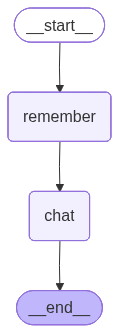

In [11]:
builder = StateGraph(MessagesState)
builder.add_node("remember", remember_node)
builder.add_node("chat", chat_node)

builder.add_edge(START, "remember")
builder.add_edge("remember", "chat")
builder.add_edge("chat", END)

graph = builder.compile(store=store)
graph

## Demo: Chat with Sachin

In [12]:
config = {"configurable": {"user_id": "sachin"}}

result = graph.invoke({"messages": [{"role": "user", "content": "Hi, my name is Sachin"}]}, config)
print(result['messages'][-1].content)

Hello Sachin! It's nice to meet you. Is there something I can help you with or would you like to chat?


In [13]:
result = graph.invoke({"messages": [{"role": "user", "content": "I build AI agents and work with LangGraph"}]}, config)
print(result['messages'][-1].content)

Nice to meet you, Sachin! It sounds like you're involved in some exciting work with AI agents and LangGraph. LangGraph is a powerful tool for building and managing AI agents, and I'm happy to chat with you about your experiences and projects.

What specific aspects of AI agent development and LangGraph are you currently working on, Sachin? Are you building agents for a particular industry or application?


In [14]:
result = graph.invoke({"messages": [{"role": "user", "content": "Explain long-term memory in AI agents"}]}, config)
print(result['messages'][-1].content)

Sachin! Long-term memory in AI agents refers to the ability of an AI system to store and retain information over an extended period, allowing it to learn, adapt, and make decisions based on past experiences.

In traditional AI systems, memory is often limited to the current session or interaction. However, with long-term memory, AI agents can:

1. **Store and retrieve knowledge**: AI agents can store information in a database or knowledge graph, allowing them to access and utilize it in future interactions.
2. **Learn from experience**: By retaining information about past interactions, AI agents can learn from their experiences, identify patterns, and make more informed decisions.
3. **Improve over time**: As AI agents accumulate more knowledge and experience, they can refine their performance, adapt to changing environments, and become more effective.

In the context of LangGraph, long-term memory can be particularly useful for building more sophisticated AI agents that can:

1. **Mai

## Stored Long-Term Memory

In [15]:
for it in store.search(("user", "sachin", "details")):
    print(it.value["data"])

User's name is Sachin
User builds AI agents and works with LangGraph


## Key Takeaways

- LangGraph enables clean separation of memory and reasoning
- Long-term memory improves personalization over time
- This pattern scales to assistants, tutors, and copilots

This notebook represents a **single production-style/not production ready chatbot** with memory.